Library imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

import utilities as utils

Loads the datacube

In [2]:
data = utils.load_dataset()
# data.head()

In [3]:
# modifies presence / absence columns to boolean - geology properties
data["Geology_Dictionary_Alkalic"] = data["Geology_Dictionary_Alkalic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Anatectic"] = data["Geology_Dictionary_Anatectic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Calcareous"] = data["Geology_Dictionary_Calcareous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Carbonaceous"] = data["Geology_Dictionary_Carbonaceous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Cherty"] = data["Geology_Dictionary_Cherty"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_CoarseClastic"] = data["Geology_Dictionary_CoarseClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Evaporitic"] = data["Geology_Dictionary_Evaporitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Felsic"] = data["Geology_Dictionary_Felsic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_FineClastic"] = data["Geology_Dictionary_FineClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Gneissose"] = data["Geology_Dictionary_Gneissose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Igneous"] = data["Geology_Dictionary_Igneous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Intermediate"] = data["Geology_Dictionary_Intermediate"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Pegmatitic"] = data["Geology_Dictionary_Pegmatitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_RedBed"] = data["Geology_Dictionary_RedBed"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Schistose"] = data["Geology_Dictionary_Schistose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Sedimentary"] = data["Geology_Dictionary_Sedimentary"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_UltramaficMafic"] = data["Geology_Dictionary_UltramaficMafic"].apply(lambda x: True if x == "Present" else False)
# modifies presence / absence columns to boolean - labels
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

Selects the data /labels used for MVT WOE baseline

In [4]:
cols_dict = utils.load_features_dict(type='MVT', baseline='preferred')
data_filtered, cols = utils.extract_cols(data, cols_dict)

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 27 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   H3_Geometry                                     object 
 1   Geology_Lithology_Majority                      object 
 2   Geology_Lithology_Minority                      object 
 3   Geology_Period_Maximum_Majority                 object 
 4   Geology_Period_Minimum_Majority                 object 
 5   Sedimentary_Dictionary                          bool   
 6   Igneous_Dictionary                              bool   
 7   Metamorphic_Dictionary                          bool   
 8   Seismic_LAB_Priestley                           float64
 9   Seismic_Moho                                    float64
 10  Gravity_GOCE_ShapeIndex                         float64
 11  Geology_Paleolatitude_Period_Minimum            float64
 12  Terrane_Proximity           

The following function finds all the neighbors and creates a new column "MVT_Deposit".
Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). 

In [5]:
data_filtered = utils.neighbor_deposits(data_filtered, type='MVT')

In [6]:
print(data_filtered['MVT_Deposit'].value_counts())
print(data_filtered['MVT_Deposit_wNeighbors'].value_counts())

MVT_Deposit
False    5162943
True        2027
Name: count, dtype: int64
MVT_Deposit_wNeighbors
False    5155482
True        9488
Name: count, dtype: int64


In [7]:
labels_filtered = data_filtered['MVT_Deposit_wNeighbors']
data_filtered = data_filtered.drop(columns=['H3_Geometry', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
cols = cols[1:-2]

Clearly the dataset has MANY outliers, as reported in the paper

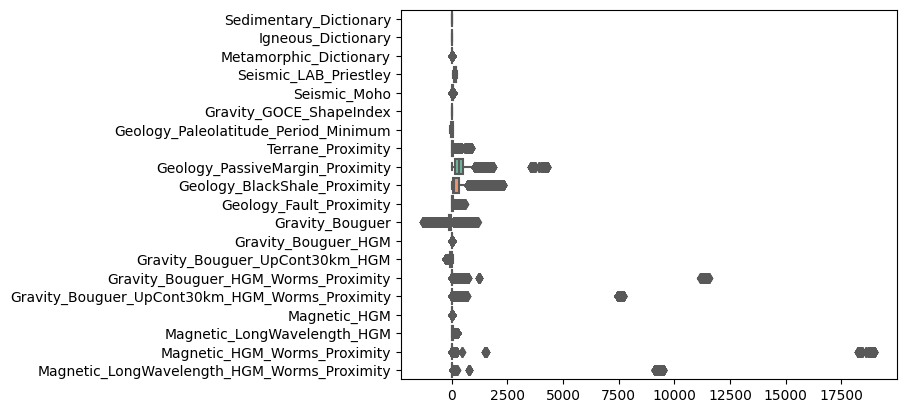

In [8]:
ax = sns.boxplot(data=data_filtered, orient="h", palette="Set2")

In [20]:
data_filtered['Geology_Lithology_Majority'].value_counts()

Geology_Lithology_Majority
Sedimentary_Siliciclastic        1713721
Other_Unconsolidated             1641673
Igneous_Intrusive_Felsic          556014
Sedimentary_Chemical              466584
Igneous_Extrusive                 310350
Metamorphic_Gneiss                203916
Metamorphic_Gneiss_Paragneiss     146287
Metamorphic_Schist                 75355
Igneous_Intrusive_Mafic            51070
Name: count, dtype: int64

In [19]:
# data_filtered['Sedimentary_Dictionary'] = data_filtered['Sedimentary_Dictionary'].astype('int')
# data_filtered['Igneous_Dictionary'] = data_filtered['Igneous_Dictionary'].astype('int')
# data_filtered['Metamorphic_Dictionary'] = data_filtered['Metamorphic_Dictionary'].astype('int')

data_filtered = pd.get_dummies(data_filtered, columns=['Geology_Lithology_Majority','Geology_Lithology_Minority','Geology_Period_Maximum_Majority','Geology_Period_Minimum_Majority'], prefix=['Geology_Lithology_Majority','Geology_Lithology_Minority','Geology_Period_Maximum_Majority','Geology_Period_Minimum_Majority'])
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 78 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   Sedimentary_Dictionary                                    int64  
 1   Igneous_Dictionary                                        int64  
 2   Metamorphic_Dictionary                                    int64  
 3   Seismic_LAB_Priestley                                     float64
 4   Seismic_Moho                                              float64
 5   Gravity_GOCE_ShapeIndex                                   float64
 6   Geology_Paleolatitude_Period_Minimum                      float64
 7   Terrane_Proximity                                         float64
 8   Geology_PassiveMargin_Proximity                           float64
 9   Geology_BlackShale_Proximity                              float64
 10  Geology_Fault_Proximity       

We can remove these outliers

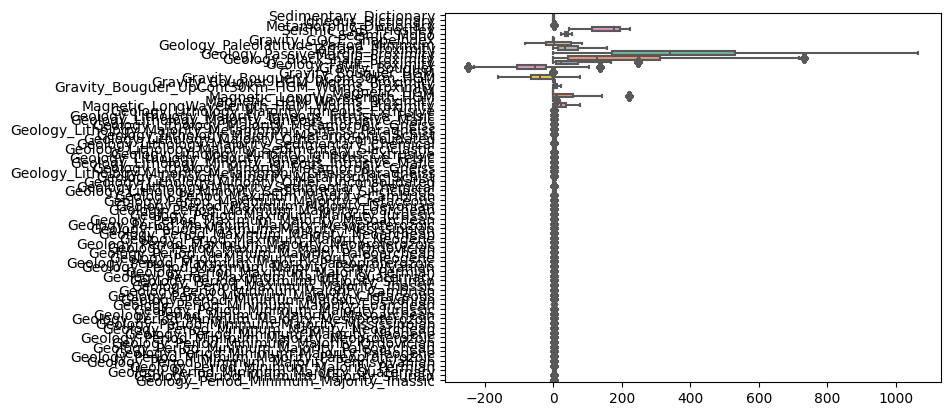

In [23]:
data_filtered = utils.tukey_remove_outliers(data_filtered)
ax = sns.boxplot(data=data_filtered, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [24]:
print(data_filtered.isna().sum())

Sedimentary_Dictionary                              0
Igneous_Dictionary                                  0
Metamorphic_Dictionary                              0
Seismic_LAB_Priestley                               0
Seismic_Moho                                     1307
                                                 ... 
Geology_Period_Minimum_Majority_Pennsylvanian       0
Geology_Period_Minimum_Majority_Permian             0
Geology_Period_Minimum_Majority_Quaternary          0
Geology_Period_Minimum_Majority_Silurian            0
Geology_Period_Minimum_Majority_Triassic            0
Length: 78, dtype: int64


In [25]:
data_filtered = utils.impute_nans(data_filtered)
print(data_filtered.isna().sum())

Sedimentary_Dictionary                           0
Igneous_Dictionary                               0
Metamorphic_Dictionary                           0
Seismic_LAB_Priestley                            0
Seismic_Moho                                     0
                                                ..
Geology_Period_Minimum_Majority_Pennsylvanian    0
Geology_Period_Minimum_Majority_Permian          0
Geology_Period_Minimum_Majority_Quaternary       0
Geology_Period_Minimum_Majority_Silurian         0
Geology_Period_Minimum_Majority_Triassic         0
Length: 78, dtype: int64


Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

In [26]:
data_filtered = utils.normalize_df(data_filtered)
ax = sns.boxplot(data=data_filtered, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


Appending 'target' column to data_filtered

In [47]:
data_filtered["target"] = labels_filtered

Merge the WOE data into the existig input datacube

In [49]:
# shows the overall IV for all variables on MVT deposits/occurences
# print(f"Information Value Overview:\n{IV_df}\n\n\n")

# shows the WOE for all variables on MVT deposits/occurences
df_result = data_filtered
# for i, col in enumerate(cols):
#     col_data = lst[i]
#     col_data = col_data.rename(columns={"Value":col,"WoE":f"{col}_WoE", "IV":f"{col}_IV"})
#     df_result = pd.merge(df_result, col_data[[col,f"{col}_WoE",f"{col}_IV"]], on=col)

Adds the latitudes to the datacube to make train, validation, and test splits

In [29]:
df_result["Latitude_EPSG4326"] = data["Latitude_EPSG4326"]
# te_df, tr_df, splits = utils.get_spatial_cross_val_idx(df_result)

In [52]:
df_result2 = df_result[df_result['target']==True]
df_result3 = df_result[df_result['target']==False].iloc[:10000]

In [56]:
df_result2 = df_result2.drop(columns=['Latitude_EPSG4326'])
df_result3 = df_result3.drop(columns=['Latitude_EPSG4326'])

In [62]:
df_result2.reset_index(drop=True)
df_result3.reset_index(drop=True)

,Sedimentary_Dictionary,Igneous_Dictionary,Metamorphic_Dictionary,Seismic_LAB_Priestley,Seismic_Moho,Gravity_GOCE_ShapeIndex,Geology_Paleolatitude_Period_Minimum,Terrane_Proximity,Geology_PassiveMargin_Proximity,Geology_BlackShale_Proximity,...,Geology_Period_Minimum_Majority_Ordovician,Geology_Period_Minimum_Majority_Paleoarchean,Geology_Period_Minimum_Majority_Paleogene,Geology_Period_Minimum_Majority_Paleoproterozoic,Geology_Period_Minimum_Majority_Pennsylvanian,Geology_Period_Minimum_Majority_Permian,Geology_Period_Minimum_Majority_Quaternary,Geology_Period_Minimum_Majority_Silurian,Geology_Period_Minimum_Majority_Triassic,target
0,1,0,0,0.745918,0.678382,0.171446,1.388223,-0.528250,0.061819,-0.446974,...,False,False,False,False,False,False,False,False,False,False
1,1,0,0,0.745918,0.678382,0.171642,1.388223,-0.466096,0.053863,-0.454319,...,False,False,False,False,False,False,False,False,False,False
2,1,0,0,0.745918,0.678382,0.171642,1.388223,-0.515116,0.049742,-0.443528,...,False,False,False,False,False,False,False,False,False,False
3,1,0,0,0.745918,0.678382,0.170092,1.388223,-0.577707,0.057659,-0.436147,...,False,False,False,False,False,False,False,False,False,False
4,1,0,0,0.745918,0.678382,0.158356,1.388223,-0.590888,0.069674,-0.439177,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0.539021,1.144632,0.133498,1.312288,-0.427179,-0.455681,-0.379420,...,False,False,True,False,False,False,False,False,False,False
9996,1,0,0,0.539022,1.144632,0.128686,1.312288,-0.401309,-0.460028,-0.368613,...,False,False,True,False,False,False,False,False,False,False
9997,1,0,0,0.539021,1.145022,0.128686,1.312288,-0.373416,-0.464309,-0.357894,...,False,False,True,False,False,False,False,False,False,False
9998,1,0,0,0.539021,1.146732,0.128686,1.312288,-0.342687,-0.468653,-0.347390,...,False,False,True,False,False,False,False,False,False,False


In [66]:
df_result2

,Sedimentary_Dictionary,Igneous_Dictionary,Metamorphic_Dictionary,Seismic_LAB_Priestley,Seismic_Moho,Gravity_GOCE_ShapeIndex,Geology_Paleolatitude_Period_Minimum,Terrane_Proximity,Geology_PassiveMargin_Proximity,Geology_BlackShale_Proximity,...,Geology_Period_Minimum_Majority_Ordovician,Geology_Period_Minimum_Majority_Paleoarchean,Geology_Period_Minimum_Majority_Paleogene,Geology_Period_Minimum_Majority_Paleoproterozoic,Geology_Period_Minimum_Majority_Pennsylvanian,Geology_Period_Minimum_Majority_Permian,Geology_Period_Minimum_Majority_Quaternary,Geology_Period_Minimum_Majority_Silurian,Geology_Period_Minimum_Majority_Triassic,target
129455,0,1,0,-0.683550,-0.479695,0.249949,1.206102e+00,-1.058588,-1.041250,-0.117300,...,False,False,False,False,False,False,False,False,False,True
129615,1,0,1,-1.473519,0.078465,0.213842,-2.802117e-01,-1.051611,-1.279358,-0.847057,...,False,False,False,False,False,False,False,False,False,True
130978,1,0,0,-0.758785,1.355414,0.179445,-2.149581e-16,-0.829206,-1.248305,-0.617319,...,False,False,False,False,False,False,False,False,False,True
131777,1,0,1,-0.758785,-0.670597,0.057376,-4.305674e-01,-0.527505,-1.360629,-0.123226,...,False,False,False,False,False,False,False,False,False,True
132132,1,0,0,-0.081669,-0.311520,0.189570,-5.058965e-01,-0.215241,-1.494987,-0.319554,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158821,1,0,0,0.426169,-1.235827,0.609110,-9.932669e-01,0.078369,-0.570700,0.600206,...,False,False,False,False,False,False,True,False,False,True
5161718,1,0,0,0.708300,0.569163,1.414679,-1.061638e+00,-0.923951,-0.671649,0.798790,...,False,False,False,False,False,False,False,False,False,True
5162476,1,0,0,0.426169,-1.103778,0.824354,-9.932669e-01,-0.395040,-0.621702,0.442840,...,False,False,False,False,False,False,True,False,False,True
5164155,1,0,0,0.708300,0.283138,1.474490,-9.932669e-01,-1.027076,-0.853777,0.546660,...,False,False,False,False,False,False,True,False,False,True


In [69]:
df_the_result = pd.concat([df_result2, df_result3], axis=0)

In [71]:
df_the_result = df_the_result.reset_index(drop=True)
df_the_result = df_the_result.sample(frac=1).reset_index(drop=True)
df_the_result

,Sedimentary_Dictionary,Igneous_Dictionary,Metamorphic_Dictionary,Seismic_LAB_Priestley,Seismic_Moho,Gravity_GOCE_ShapeIndex,Geology_Paleolatitude_Period_Minimum,Terrane_Proximity,Geology_PassiveMargin_Proximity,Geology_BlackShale_Proximity,...,Geology_Period_Minimum_Majority_Ordovician,Geology_Period_Minimum_Majority_Paleoarchean,Geology_Period_Minimum_Majority_Paleogene,Geology_Period_Minimum_Majority_Paleoproterozoic,Geology_Period_Minimum_Majority_Pennsylvanian,Geology_Period_Minimum_Majority_Permian,Geology_Period_Minimum_Majority_Quaternary,Geology_Period_Minimum_Majority_Silurian,Geology_Period_Minimum_Majority_Triassic,target
0,1,0,0,-0.344992,0.005720,0.221032,-6.256971e-01,-0.945826,-1.429471,-0.827637,...,True,False,False,False,False,False,False,False,False,True
1,1,0,0,-0.107796,-0.573796,0.207489,-3.071365e-01,-1.046111,-1.307303,2.416041,...,False,False,False,False,False,False,False,True,False,True
2,1,0,0,0.745918,0.599384,0.185874,1.388223e+00,0.195928,0.149672,-0.616492,...,False,False,False,False,False,False,False,False,False,False
3,1,0,0,0.426169,0.895012,0.137457,1.312288e+00,-0.776893,-0.185188,-0.194850,...,False,False,True,False,False,False,False,False,False,False
4,1,0,0,0.934006,0.109909,0.069413,1.388223e+00,-0.907096,0.506925,-0.641022,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,1,0,0,0.539021,0.745654,0.154398,1.388223e+00,-0.183866,-0.170793,-0.480008,...,False,False,False,False,False,False,False,False,False,False
19484,0,0,0,0.934006,0.050948,-0.061555,1.388223e+00,-0.860584,0.339336,-0.323509,...,False,False,False,False,False,False,False,False,False,False
19485,1,0,0,0.670683,2.055748,1.033000,-2.149581e-16,0.762498,1.455672,0.863656,...,False,False,False,False,False,False,False,False,False,True
19486,0,0,0,0.934006,-0.128886,-0.156924,1.388223e+00,-0.864239,0.515501,-0.311296,...,False,False,False,False,False,False,False,False,False,False


In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_the_result.drop(columns=['target']), df_the_result['target'], test_size=0.2, random_state=777)

In [74]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15590, 78)
X_test shape: (3898, 78)
y_train shape: (15590,)
y_test shape: (3898,)


In [75]:
hist_gbm_classifier = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=70,              # Number of boosting iterations (equivalent to n_estimators)
    max_depth=6,              # Maximum tree depth
    min_samples_leaf=48,      # Minimum samples required for a leaf node
    max_leaf_nodes=64,        # Maximum number of leaf nodes
    verbose=1                 # Show progress bars
)

In [76]:
hist_gbm_classifier.fit(X_train, y_train)
y_pred = hist_gbm_classifier.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC score:{auc_score}")

Binning 0.009 GB of training data: 

0.050 s
Binning 0.001 GB of validation data: 0.029 s
Fitting gradient boosted rounds:
[1/70] 1 tree, 11 leaves, max depth = 6, train loss: 0.68290, val loss: 0.68288, in 0.013s
[2/70] 1 tree, 9 leaves, max depth = 6, train loss: 0.67319, val loss: 0.67315, in 0.012s
[3/70] 1 tree, 8 leaves, max depth = 5, train loss: 0.66368, val loss: 0.66361, in 0.008s
[4/70] 1 tree, 9 leaves, max depth = 6, train loss: 0.65436, val loss: 0.65425, in 0.005s
[5/70] 1 tree, 11 leaves, max depth = 6, train loss: 0.64521, val loss: 0.64508, in 0.008s
[6/70] 1 tree, 8 leaves, max depth = 6, train loss: 0.63624, val loss: 0.63608, in 0.005s
[7/70] 1 tree, 9 leaves, max depth = 6, train loss: 0.62744, val loss: 0.62726, in 0.007s
[8/70] 1 tree, 10 leaves, max depth = 6, train loss: 0.61880, val loss: 0.61859, in 0.006s
[9/70] 1 tree, 11 leaves, max depth = 5, train loss: 0.61032, val loss: 0.61009, in 0.007s
[10/70] 1 tree, 10 leaves, max depth = 6, train loss: 0.60200, val loss: 0.60175, in 0.008s
[11/70] 

In [77]:
gbm_classifier = GradientBoostingClassifier(
    learning_rate=0.01,          # Learning Rate
    n_estimators=70,            # Number of trees
    max_depth=6,                # Maximum tree depth
    min_samples_split=48,       # Minimum samples required to split an internal node
    min_samples_leaf=48,        # Minimum samples required for a leaf node
    max_leaf_nodes=64,          # Maximum number of leaf nodes
    verbose=1                   # Show progress bars
)

In [78]:
gbm_classifier.fit(X_train, y_train)
y_pred = gbm_classifier.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC score:{auc_score}")

      Iter       Train Loss   Remaining Time 
         1           1.3658            5.69s
         2           1.3463            5.82s
         3           1.3273            5.46s
         4           1.3086            5.09s
         5           1.2903            5.11s
         6           1.2723            5.23s
         7           1.2547            5.06s
         8           1.2374            4.92s
         9           1.2204            4.79s
        10           1.2038            4.68s
        20           1.0527            4.14s
        30           0.9253            3.23s
        40           0.8168            2.43s
        50           0.7235            1.60s
        60           0.6427            0.81s
        70           0.5724            0.00s
Test AUC score:0.9984210526315789


In [ ]:
auc_score = roc_auc_score(tr_df["target"],tr_df["WOE Total"])
print(f"Train AUC score:{auc_score}")
auc_score = roc_auc_score(te_df["target"],te_df["WOE Total"])
print(f"Test AUC score:{auc_score}")
auc_score = roc_auc_score(df_result["target"],df_result["WOE Total"])
print(f"All AUC score:{auc_score}")

Shows the cross validation splits (train / val); test split is held out of cross validation

In [ ]:
for i, (train_index, val_index) in enumerate(splits):
    print(f"Fold {i}:")
    print(f"  Train: groups={np.unique(tr_df.iloc[train_index.tolist()]['group'].tolist())}")
    print(f"  Val: groups={np.unique(tr_df.iloc[val_index.tolist()]['group'].tolist())}")